#### Business Problem

Customer Churn is one of the nightmares any organisation wants to see. It incurs expenditures on any organization and loss of brand value. To tackle this we need to understand the customer base that are likely to be churned. The Customer churn app that we have proposed here predicts the likelihood of customer getting churned or not for telecom managers to buid customer oriented plans and services.

#### Metric

   In classification predictions model returns results in four types of outcomes that could occur.

>- **True positives** predicticted observation belongs to a correct class.

>- **True negatives** predicticted observation does not belongs to a correct class.

>- **False positives** predicticted observation belongs to a class, however in reality it does not.

>- **False negatives** predicticted observation does not belongs to a class, however in reality it does.

   In this project we have used **Accuracy** as our evaulation metric whic is defined as 

                           Accuracy = TP+TN/TP+FP+FN+TN

In [1]:
import pandas as pd
import joblib
import numpy as np
import logging
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import shap


import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Data/Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
def basic_info(df):
    '''
    Function to get basic information of the data set
    input: dataframe
    output: No of rows and columns    
    '''
    data_dim = [
        ['Summary Statistics for: ', 'Bank Data'],
        ['Number of Rows: ', df.shape[0]],
        ['Number of Columns: ', df.shape[1]]
        ]
    temp_bank_df_df = pd.DataFrame(data_dim)
    return temp_bank_df_df.head()


basic_info(df)

,0,1
0,Summary Statistics for:,Bank Data
1,Number of Rows:,7043
2,Number of Columns:,21


In [6]:
def data_statistics(df):
    '''
    Basic Statistics information of bank data
    input: bank df
    output: Information of mean, percentiles, Null values in columns etc.    
    '''
    df_des = df.describe().T
    NA_Col = pd.DataFrame(df.isnull().sum(), columns=['NA']) 
    stat_df = pd.concat([df_des,NA_Col], axis=1)
    #stat_df = stat_df.reindex(df_des.index)
    return stat_df


data_statistics(df)

,count,mean,std,min,25%,50%,75%,max,NA
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00,0
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00,0
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,0
customerID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Partner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Dependents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
PhoneService,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
MultipleLines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
InternetService,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


##### Remove unwanted columns

    Remove Constant and Duplicate Columns.

    From the statistics summary we observe that 'TotalCharges' column has no negative values yet it has blank rows that does not show in so we will deal with it in missing values. Also 'customerID','Dependents','PhoneService','MultipleLines', 'PaperlessBilling'and 'PaymentMethod' columns will not add value to features, hence we can also delete them

In [7]:
def remove_cols(df):
    '''
    Check and remove the unwanted columns
    input: df
    output: cleaned dataframe    
    '''
    Constant_Values = df.columns[df.eq(df.iloc[0]).all()].tolist()
    Duplicate_Columns = df.columns[df.T.duplicated(keep='first').T]  # Only report second column as duplicate
    
    df = df.drop(Constant_Values, axis=1)
    df = df.drop(Duplicate_Columns, axis=1)
    df = df.drop(['customerID','Dependents','PhoneService','MultipleLines', 'PaperlessBilling','PaymentMethod'], axis = 1)
    return df

df = remove_cols(df)

In [8]:
# Missing Values

def missing_values_table(df):
    '''
    Check the missing values in the data columns
    input: df
    output: Dataframe of columns and their missing value percent    
    '''
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    missing_val = df.isna().sum()
    missing_val_percent = 100 * missing_val / len(df)
    mis_val_table = pd.concat([missing_val, missing_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    return mis_val_table_ren_columns

missing_values = missing_values_table(df)
missing_values

,Missing Values,% of Total Values
TotalCharges,11,0.2


#### Exploratory Data Analysis

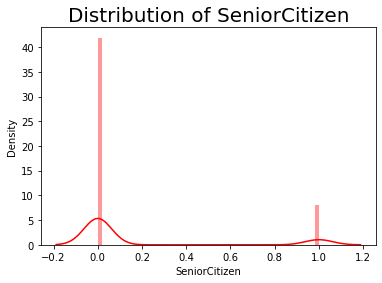

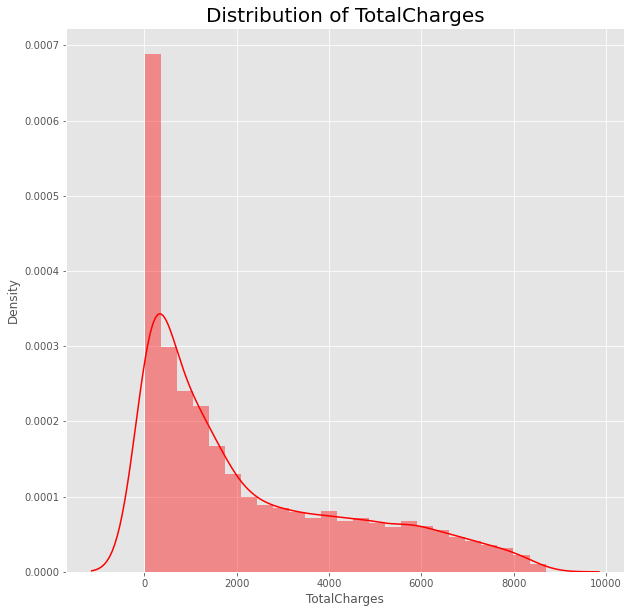

In [9]:
# Check the distribution of columns
def plot_dist(df, x:str):
    '''
    Check the distributions in the data columns
    input: df, column name
    output: distribution plots    
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (10,10)
    sns.distplot(df[x], color = 'red')
    plt.title("Distribution of {}".format(x), fontsize = 20)
    plt.show()

data_cols = ['SeniorCitizen', 'TotalCharges']
for col in data_cols:
    plot_dist(df, col )

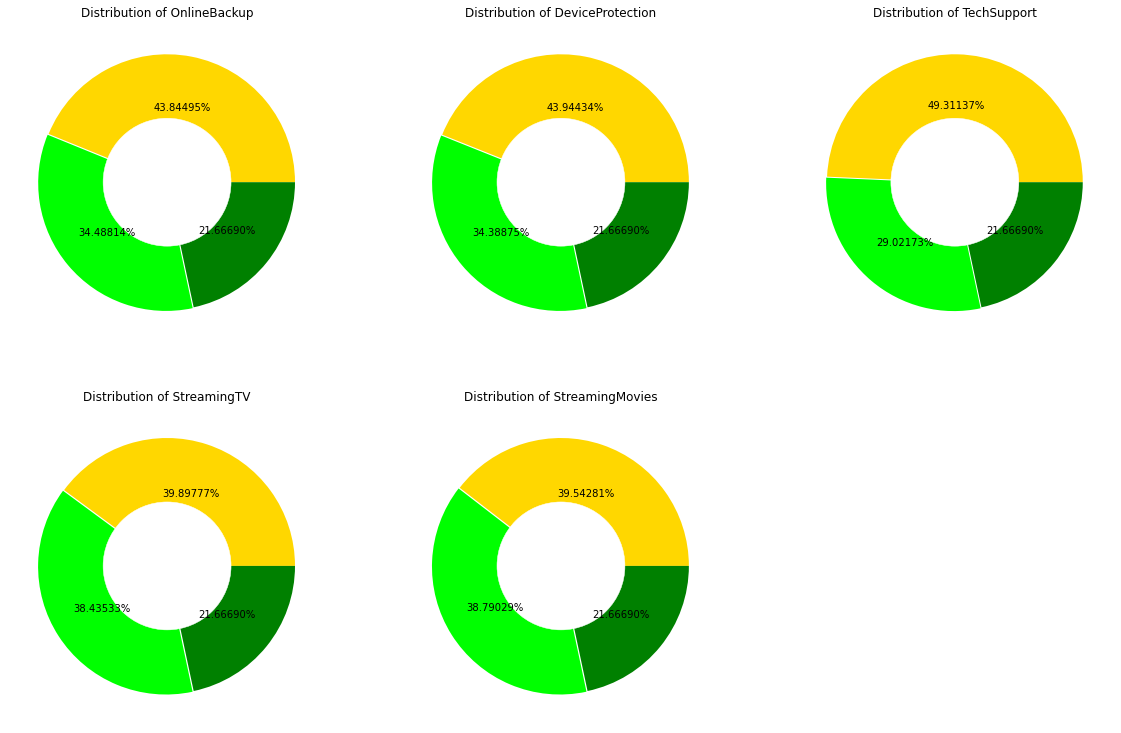

In [10]:
fig, ax = plt.subplots(1,5,figsize=(20,20))
cols = ['OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i,column in enumerate(cols):
    plt.subplot(3,3,i+1)
    count = df[column].value_counts()
    color = ['gold', 'lime', 'green']
    label = "No", "Yes", "No Internet Service"
    explode = [0, 0.01,0]

    donut_circle = plt.Circle((0, 0), 0.5, color = 'white')

    plt.rcParams['figure.figsize'] = (25, 25)
    plt.pie(count, colors = color, shadow = False, explode = explode, autopct = '%.5f%%')
    plt.title('Distribution of {}'.format(column), fontsize = 12)
    p = plt.gcf()
    p.gca().add_artist(donut_circle)
plt.show()

###### Correlation 

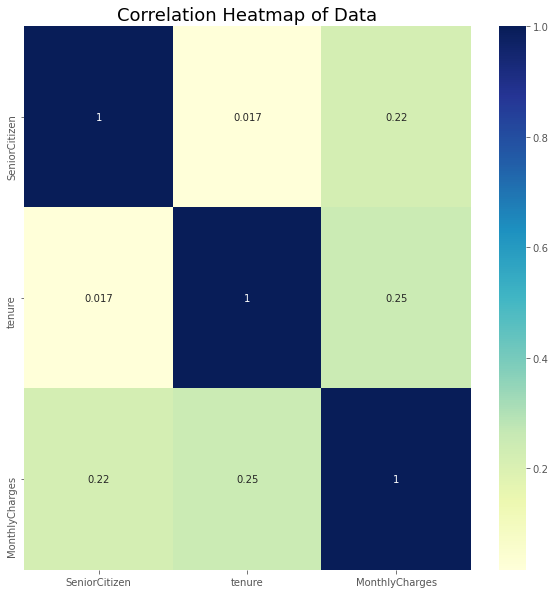

In [11]:
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('ggplot')

sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')
plt.title('Correlation Heatmap of Data', fontsize = 18)
plt.show()

#### Feature Engineering

    Feature Engineering is done usine `Scikit-Learn` pipeline and ColumnTransformers.
    ColumnTransformers performs:
    > Missing value imputation
    > Scaling of non-bool values by StandardScaler
    > One hot encoding for categorical variables

In [12]:
train_features = df.drop(columns=['Churn'])
label = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(train_features, label, test_size=0.20, random_state=42)

cat_cols = list(X_train.select_dtypes('object').columns)
num_cols = list(X_train.select_dtypes('number').columns)

In [13]:
print(cat_cols)
print(num_cols)

['gender', 'Partner', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'TotalCharges']
['SeniorCitizen', 'tenure', 'MonthlyCharges']


In [14]:
num_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])

cat_transform = Pipeline(steps=[('onehotenc', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                         ])
col_transformer = ColumnTransformer(transformers=[  ('num_transform',num_transform, num_cols),
                                                    ('cat_transform', cat_transform, num_cols)
                                                  ], remainder='drop')

col_transformer

ColumnTransformer(transformers=[('num_transform',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges']),
                                ('cat_transform',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['SeniorCitizen', 'tenure',
                                  'MonthlyCharges'])])

#### Model Training

    Scikit Learn Pipeline is used to build the model using Random Forest. For hyperparameter we used RandomSearchCV

In [15]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
bootstrap = [True, False]
class_weight = ['balanced']
criterion =  ['gini', 'entropy'] 


In [16]:
def build_model():
    '''
    Machine Learning classification model function that executes following steps:
      1. Building Machine Learning pipeline
      2. Running GridSearchCV for Hyper-parameter tunning
      
      input: None
    output: RandomSearch best model.
    '''
    pipeline_clf = Pipeline([
                     ('transform_column', col_transformer),
                     ('clf', RandomForestClassifier(random_state=42))
                     ]) 

# find best model from random search

    param_grid = {'clf__n_estimators': n_estimators,               
                'clf__max_depth': max_depth,
                'clf__min_samples_split': min_samples_split,
                'clf__bootstrap': bootstrap,
                'clf__criterion': criterion,
                'clf__class_weight': class_weight }

    best_clf = RandomizedSearchCV(pipeline_clf, param_distributions= param_grid, verbose=5, n_jobs=-1, scoring= 'accuracy', cv = 3, refit=True, return_train_score=True)
    return best_clf

In [17]:
model = build_model()

In [18]:
model.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('transform_column',
                                              ColumnTransformer(transformers=[('num_transform',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['SeniorCitizen',
                                                                                'tenure',
                                                                                'MonthlyCharges']),
                                                                              ('ca

In [19]:
model.best_params_

{'clf__n_estimators': 100,
 'clf__min_samples_split': 2,
 'clf__max_depth': 90,
 'clf__criterion': 'gini',
 'clf__class_weight': 'balanced',
 'clf__bootstrap': True}

#### Evaluation
    
       For Model Evaluation we train the model using the tunned hyperparameters and checked the result on confusion matrix.

In [26]:
clf_eval = Pipeline([
                     ('transform_column', col_transformer),
                     ('clf', RandomForestClassifier(random_state=42,n_estimators=100, min_samples_split=2, max_depth=90, criterion='gini', class_weight='balanced', bootstrap=True ))
                     ]) 

In [27]:
clf_eval.fit(X_train, y_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges']),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SeniorCitizen',

In [28]:
y_pred = clf_eval.predict(X_test)

##### Model Metric

In [29]:
#Confusion Matrix
model_report = classification_report(y_test, y_pred)
print(model_report)

              precision    recall  f1-score   support

          No       0.86      0.85      0.85      1036
         Yes       0.60      0.61      0.60       373

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409

